## 추론(예측) 기반 기법과 신경망

## word2vec : 워드투벡터
2013년 구글의 토마스미콜로프(Tomas Mikolov)의 팀이 개발<br>
<b>word2vec</b> 알고리즘은 <b>신경망 모델</b>을 사용 하여 큰 텍스트 코퍼스에서 단어 연관성을 학습. 학습이 끝나면 이러한 모델은 동의어 단어를 감지하거나 부분 문장에 대한 추가 단어를 제안 할 수 있다. word2vec는 <b>벡터</b> 라고하는 특정 숫자 목록을 사용하여 각각의 고유 한 단어를 나타낸다 . 벡터는 간단한 수학적 함수 ( 벡터 간의 코사인 유사성 ) 가 해당 벡터가 나타내는 단어 간의 의미 유사성 수준을 나타내 도록 신중하게 선택 된다.


## [1] 신경망에서의 단어 처리

In [1]:
import numpy as np

text = 'You say goodbye and I say hello.'
# {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

# 여기서 'you'만  one-hot 인코딩으로 표현
c = np.array([[1,0,0,0,0,0,0]])
print('c:\n',c)

W = np.random.randn(7,3)
print('W:\n',W)

h = np.matmul(c,W)     # (1,7) * (7,3)  = (1,3)
print('h:\n',h)

c:
 [[1 0 0 0 0 0 0]]
W:
 [[ 0.31689378 -0.70016484 -0.95718467]
 [ 0.02837396  0.49564798  0.18962945]
 [-1.62551532 -0.07725917  0.52021114]
 [-0.35868878 -1.12561745  1.40767805]
 [-0.37076105 -0.10339388  0.92907773]
 [-0.6461131  -0.76190714  0.53924261]
 [-0.29541276  1.38433858 -1.28808039]]
h:
 [[ 0.31689378 -0.70016484 -0.95718467]]


In [2]:
### Matmul 노드

class MatMul:
    def __init__(self,W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None
        
    def forward(self,x):         # 순전파
        W, = self.params
        out = np.dot(x,W)
        self.x = x
        return out
    
    def backward(self,dout):     # 역전파
        W, = self.params
        dx = np.dot(dout,W.T)
        dW = np.dot(self.x.T,dout)
        self.grads[0][...] = dW    # 깊은 복사(deep copy)
        return dx        

In [3]:
text = 'You say goodbye and I say hello.'
# {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

# 여기서 'you'만  one-hot 인코딩으로 표현
c = np.array([[1,0,0,0,0,0,0]])
print('c:\n',c)

W = np.random.randn(7,3)
print('W:\n',W)

layer = MatMul(W)

h = layer.forward(c)   # (1,7) * (7,3)  = (1,3)
print('h:\n',h)

c:
 [[1 0 0 0 0 0 0]]
W:
 [[ 0.76540361  0.79038468  0.444948  ]
 [-1.07754949  1.13160567 -0.33401549]
 [ 1.20507044 -1.51867833 -0.33507828]
 [-0.99146735 -1.3366914   0.04421586]
 [ 1.20557166 -0.04629662 -0.30140835]
 [ 0.97573407 -1.16858756  1.52360551]
 [-0.39521711  0.70631451 -1.583333  ]]
h:
 [[0.76540361 0.79038468 0.444948  ]]


## [2] 단순한 word2vec

### CBOW (Continuous Bag of Words) 모델

#### Word2Vec에는 CBOW(Continuous Bag of Words)와 Skip-Gram 두 가지 방식이 있다
- $ CBOW $ 는 주변에 있는 단어들을 가지고, 중간에 있는 단어들을 예측하는 방법 <br>
  타깃(target)은 중앙 단어 그 주변 단어들이 맥락(contexts)이다
- $ Skip-Gram $ 은 중간에 있는 단어로 주변 단어들을 예측하는 방법

#### BOW(Bag of Words) : 단어들의 순서는 전혀 고려하지 않고, 단어들의 출현 빈도(frequency)에만 집중하는 텍스트 데이터의 수치화 표현 방법

BOW를 만드는 과정<br>
(1) 우선, 각 단어의 고유한 인덱스(Index)를 부여한다.<br>
(2) 각 인덱스의 위치에 단어 토큰의 등장 횟수를 기록한 벡터(Vector)를 만든다.<br>

"정부가 발표하는 물가상승률과 소비자가 느끼는 물가상승률은 다르다."<br>
('정부': 0, '가': 1, '발표': 2, '하는': 3, '물가상승률': 4, '과': 5, '소비자': 6, '느끼는': 7, '은': 8, '다르다': 9) <br>
BOW: [1, 2, 1, 1, 2, 1, 1, 1, 1, 1]  ==> '가' 와 '물가상승률' 은 2회 발생

https://wikidocs.net/22650

In [4]:
# (CBOW 전체구조의 Preview)
# 샘플 맥락 데이터 : 2개의 주변 단어를 맥락으로 중간 단어('say')를 예측
text = 'You say goodbye and I say hello.'

# 2개의 주변 단어를 one-hot 벡터 생성
c0 = np.array([[1,0,0,0,0,0,0]])  # 'you'   , (1,7)
c1 = np.array([[0,0,1,0,0,0,0]])  # 'goodbye' (1,7)

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)   
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)  # (1,7) * (7,3)  = (1,3)
h1 = in_layer1.forward(c1)  # (1,7) * (7,3)  = (1,3)
h = 0.5 * (h0 + h1)         # 입력층이 여러 개이면 전체를 평균
s = out_layer.forward(h)    # (1,3) * (3,7)  = (1,7) ,최종 출력
print(s,s.shape)            # (1, 7), 7개 단어의 스코어
np.argmax(s)

[[-0.12102364  3.45347547 -2.53891551 -0.0995367   0.22463423 -1.40234936
   1.0280746 ]] (1, 7)


1

## [3] 학습 데이터 준비

### 맥락과 타깃을 생성

In [5]:
from mynlp import preprocess

In [6]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)      # 8개
print(id_to_word)  # 7개

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [7]:
# target : (6,)
target = corpus[1:-1]     # 타깃(중간단어) : [1 2 3 4 1 5], 첫번째와 마지막 단어 제외
print('target:',target)

target: [1 2 3 4 1 5]


In [8]:
# contexts : (6,2)
print('corpus:',corpus)

contexts = []
for idx in(range(1,len(corpus) - 1)): # 1 to 6 ,6회, 중간단어마다 앞뒤 주변단어 조합 6가지 
    cs = []
    for t in range(-1,2) : # 3회 , (-1, 0 ,1)
        if t == 0: # 2번째는 skip
            continue
        cs.append(corpus[idx + t]) # corpus[1-1,1+1],[2-1,2+1],...
    contexts.append(cs)
print('contexts:',contexts)

corpus: [0 1 2 3 4 1 5 6]
contexts: [[0, 2], [1, 3], [2, 4], [3, 1], [4, 5], [1, 6]]


In [9]:
# contexts와 target을 구하는 함수
def create_contexts_target(corpus,window_size=1):
    target = corpus[window_size:-window_size]  

    contexts = []
    for idx in(range(window_size,len(corpus) - window_size)): 
        cs = []
        for t in range(-window_size,window_size+1) : 
            if t == 0: 
                continue
            cs.append(corpus[idx + t]) 
        contexts.append(cs)
    return np.array(contexts),np.array(target)  

In [10]:
contexts,target = create_contexts_target(corpus,window_size=1)
print(contexts,contexts.shape)
# 맥락(contexts) : 예측할 단어의 주변 단어
# {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
# window_size=1 일 경우 : 주변 단어를 중간 단어에 앞,뒤로 1개만 사용
# [[0 2]   : 'you', 'goodbye'
#  [1 3]   : 'say', 'and'
#  [2 4]   : 'goodbye', 'i'
#  [3 1]   : 'and', 'say'
#  [4 5]   : 'i', 'hello'
#  [1 6]]  : 'say', '.'

# window_size=2 일 경우 : : 주변 단어를 중간 단어에 앞,뒤로 2개 사용
# [[0 1 3 4]
#  [1 2 4 1]
#  [2 3 1 5]
#  [3 4 5 6]]

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]] (6, 2)


In [11]:
print(target)  # (6,)
# 타깃(target) : 예측할 단어, 중간단어, 6개
# ['say','goodbye','and','i','say','hello']
# [1 2 3 4 1 5]

[1 2 3 4 1 5]


### 맥락과 타깃을 원핫 표현으로 변환

In [12]:
# 원핫 변환 함수

# target [1 2 3 4 1 5]을 변환하는 경우를 주석으로 설명 
def convert_one_hot(corpus, vocab_size):  # [1 2 3 4 1 5], 7
    N = corpus.shape[0] # (6,) --> 6

    if corpus.ndim == 1: # target [1 2 3 4 1 5], 1차원인경우 ==> 2차원으로 출력
        one_hot = np.zeros((N, vocab_size), dtype=np.int32) # 0으로 초기화된 (6,7) 2차원 배열 생성 
        for idx, word_id in enumerate(corpus): # 6회 반복
            one_hot[idx, word_id] = 1  # one_hot[0,1] = 1, [1,2]=1, [2,3] = 1,...,  [3,4],[4,1],[5,5] = 1...

    elif corpus.ndim == 2: # contexts 2차원 인경우 ==> 3차원으로 출력
        C = corpus.shape[1] # (6,2) --> 2
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32) # 0으로 초기화된 (6,2,7) 3차원 배열 생성 
        for idx_0, word_ids in enumerate(corpus): # 6회
            for idx_1, word_id in enumerate(word_ids): #  2회
                one_hot[idx_0, idx_1, word_id] = 1  

    return one_hot

In [13]:
vocab_size = len(word_to_id)
print(vocab_size)  # 7
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

7


In [14]:
print(contexts.shape)  # (6, 2, 7)
print(contexts)

(6, 2, 7)
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


In [15]:
print(target.shape)  # (6,7)
print(target)

(6, 7)
[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


## [4] CBOW 신경망 모델 구현

In [16]:
from nn_layers import MatMul, SoftmaxWithLoss, Adam

In [17]:
#  다중 분류 모델 : Softmax 사용
class SimpleCBOW:
    def __init__(self,vocab_size,hidden_size):   # 어휘수 : 7개, 은닉층의 뉴런 : 3
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01*np.random.randn(V,H).astype('f')   # (7,5) 
        W_out = 0.01*np.random.randn(H,V).astype('f')  # (5,7)
        
        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모은다
        layers = [self.in_layer0,self.in_layer1,self.out_layer]
        self.params, self.grads = [],[]
        for layer in layers: # 3회
            self.params += layer.params
            self.grads += layer.grads
       
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vec = W_in   
        
    def predict(self,contexts) :  # contexts : (6,2,7)
        h0 = self.in_layer0.forward(contexts[:,0,:])  # (6,7) , 맥락의 첫번째 단어 
        h1 = self.in_layer1.forward(contexts[:,1,:])  # (6,7) , 맥락의 두번째 단어 
        
        h = (h0 + h1) * 0.5  # 평균
        
        score = self.out_layer.forward(h)
        return self.loss_layer.softmax(score) # softmax()함수로 확률값으로 출력
    
    def forward(self,contexts,target): # contexts : (6,2,7), target : (6,7)
        h0 = self.in_layer0.forward(contexts[:,0,:])  # (6,7) , 맥락의 첫번째 단어 
        h1 = self.in_layer1.forward(contexts[:,1,:])  # (6,7) , 맥락의 두번째 단어 
        
        h = (h0 + h1) * 0.5  # 평균
        
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score,target)
        return loss
    
    def backward(self,dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer0.backward(da)
        self.in_layer1.backward(da)
        return None

### Trainer 클래스

In [18]:
import time

def remove_duplicate(params, grads):
    '''
    매개변수의 중복 제거 함수
    매개변수 배열 중 중복되는 가중치를 하나로 모아
    그 가중치에 대응하는 기울기를 더한다.
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 가중치 공유 시
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 경사를 더함
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 가중치를 전치행렬로 공유하는 경우(weight tying)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # 뒤섞기
            idx = np.random.permutation(np.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 기울기 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 손실 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
        plt.ylabel('손실')
        plt.show()   

In [19]:
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)  # 7
contexts,target = create_contexts_target(corpus,window_size)

target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

print(contexts,contexts.shape)  # (6, 2, 7)
print(target,target.shape)  # (6,7)

[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]] (6, 2, 7)
[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]] (6, 7)


In [20]:
# 학습
model = SimpleCBOW(vocab_size,hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts,target,max_epoch,batch_size)

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

| 에폭 288 |  반복 1 / 2 | 시간 0[s] | 손실 0.92
| 에폭 289 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 290 |  반복 1 / 2 | 시간 0[s] | 손실 0.89
| 에폭 291 |  반복 1 / 2 | 시간 0[s] | 손실 0.87
| 에폭 292 |  반복 1 / 2 | 시간 0[s] | 손실 0.82
| 에폭 293 |  반복 1 / 2 | 시간 0[s] | 손실 0.98
| 에폭 294 |  반복 1 / 2 | 시간 0[s] | 손실 0.90
| 에폭 295 |  반복 1 / 2 | 시간 0[s] | 손실 0.93
| 에폭 296 |  반복 1 / 2 | 시간 0[s] | 손실 0.80
| 에폭 297 |  반복 1 / 2 | 시간 0[s] | 손실 0.79
| 에폭 298 |  반복 1 / 2 | 시간 0[s] | 손실 0.96
| 에폭 299 |  반복 1 / 2 | 시간 0[s] | 손실 0.87
| 에폭 300 |  반복 1 / 2 | 시간 0[s] | 손실 0.95
| 에폭 301 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 302 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 303 |  반복 1 / 2 | 시간 0[s] | 손실 0.84
| 에폭 304 |  반복 1 / 2 | 시간 0[s] | 손실 0.94
| 에폭 305 |  반복 1 / 2 | 시간 0[s] | 손실 0.85
| 에폭 306 |  반복 1 / 2 | 시간 0[s] | 손실 0.85
| 에폭 307 |  반복 1 / 2 | 시간 0[s] | 손실 0.84
| 에폭 308 |  반복 1 / 2 | 시간 0[s] | 손실 0.84
| 에폭 309 |  반복 1 / 2 | 시간 0[s] | 손실 0.82
| 에폭 310 |  반복 1 / 2 | 시간 0[s] | 손실 0.85
| 에폭 311 |  반복 1 / 2 | 시간 0[s] | 손실 0.91
| 에폭 312 |  반복 1

| 에폭 629 |  반복 1 / 2 | 시간 0[s] | 손실 0.40
| 에폭 630 |  반복 1 / 2 | 시간 0[s] | 손실 0.26
| 에폭 631 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 632 |  반복 1 / 2 | 시간 0[s] | 손실 0.37
| 에폭 633 |  반복 1 / 2 | 시간 0[s] | 손실 0.37
| 에폭 634 |  반복 1 / 2 | 시간 0[s] | 손실 0.26
| 에폭 635 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 636 |  반복 1 / 2 | 시간 0[s] | 손실 0.34
| 에폭 637 |  반복 1 / 2 | 시간 0[s] | 손실 0.28
| 에폭 638 |  반복 1 / 2 | 시간 0[s] | 손실 0.34
| 에폭 639 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 640 |  반복 1 / 2 | 시간 0[s] | 손실 0.28
| 에폭 641 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 642 |  반복 1 / 2 | 시간 0[s] | 손실 0.26
| 에폭 643 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 644 |  반복 1 / 2 | 시간 0[s] | 손실 0.34
| 에폭 645 |  반복 1 / 2 | 시간 0[s] | 손실 0.28
| 에폭 646 |  반복 1 / 2 | 시간 0[s] | 손실 0.36
| 에폭 647 |  반복 1 / 2 | 시간 0[s] | 손실 0.55
| 에폭 648 |  반복 1 / 2 | 시간 0[s] | 손실 0.36
| 에폭 649 |  반복 1 / 2 | 시간 0[s] | 손실 0.36
| 에폭 650 |  반복 1 / 2 | 시간 0[s] | 손실 0.17
| 에폭 651 |  반복 1 / 2 | 시간 0[s] | 손실 0.44
| 에폭 652 |  반복 1 / 2 | 시간 0[s] | 손실 0.27
| 에폭 653 |  반복 1

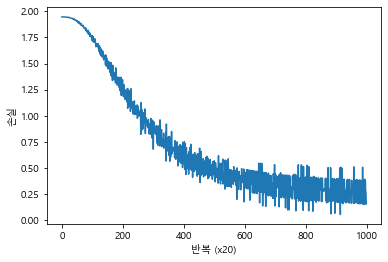

In [21]:
# 시각화
trainer.plot()

In [22]:
# W_in : 인스턴스 변수에 단어의 분산 표현
word_vecs = model.word_vec   
for word_id, word in id_to_word.items():
    print('%10s : '%word, word_vecs[word_id])

       you :  [ 1.4812576   0.85693437  1.4553224  -0.88635993  0.92768884]
       say :  [ 0.3807971  -1.395479    0.27998528  1.3424903  -0.13011557]
   goodbye :  [-0.5035288   1.0958378  -0.44690058 -1.1751492   1.1997215 ]
       and :  [ 1.3054422 -1.1450835  1.2860813  1.0979258 -1.3286545]
         i :  [-0.5057965   1.0873369  -0.46223965 -1.1353451   1.1644701 ]
     hello :  [ 1.4938418   0.8724293   1.4572747  -0.89216095  0.93766457]
         . :  [-1.3118908 -1.177932  -1.2744582  1.1794847  1.3608272]


### 예측 및 정확도 평가

In [23]:
# 예측
h = model.predict(contexts)
print(h,h.shape)  # (6,7)
print('예측값:',np.argmax(h,axis=1))
print('실제값:',np.argmax(target,axis=1))

[[1.92220321e-03 9.62426154e-01 1.99931531e-03 2.91686802e-02
  1.97122302e-03 5.92993765e-04 1.91943052e-03]
 [4.73671401e-03 7.83572546e-03 4.86201733e-01 4.70460283e-05
  4.86917128e-01 9.52621894e-03 4.73543512e-03]
 [7.84438156e-03 5.11678694e-02 2.98581939e-04 9.23833708e-01
  2.96058848e-04 8.73517508e-03 7.82422489e-03]
 [4.73671401e-03 7.83572546e-03 4.86201733e-01 4.70460283e-05
  4.86917128e-01 9.52621894e-03 4.73543512e-03]
 [1.99787811e-03 9.61881174e-01 2.09467270e-03 2.93529697e-02
  2.06546948e-03 6.12579031e-04 1.99525703e-03]
 [4.38956991e-03 2.06298376e-04 9.88171997e-03 5.34939974e-03
  9.84462976e-03 9.65963573e-01 4.36480891e-03]] (6, 7)
예측값: [1 4 3 4 1 5]
실제값: [1 2 3 4 1 5]


In [24]:
# 정확도
preds = np.argmax(h,1)
t = np.argmax(target,1)
print('target :',t)
print('predict:',preds)
accuracy = np.sum(np.equal(preds,t))/len(t)
print('정확도:', np.round(accuracy,4))

target : [1 2 3 4 1 5]
predict: [1 4 3 4 1 5]
정확도: 0.8333


In [25]:
for idx in range(len(t)):
    print(id_to_word[t[idx]], ' : ', id_to_word[preds[idx]])

say  :  say
goodbye  :  i
and  :  and
i  :  i
say  :  say
hello  :  hello
